# Imbalanced

In [811]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

In [812]:
df = pd.read_excel("data/imbalanced_dataset_wdev.xlsx")

In [813]:
df

,Record,Loss,Dev,AY,EvalYr
0,1,0.0000,1,2000,2001
1,1,1.7500,2,2000,2002
2,1,2.1875,3,2000,2003
3,1,2.2750,4,2000,2004
4,1,2.4500,5,2000,2005
...,...,...,...,...,...
1519,254,8.0000,2,2003,2005
1520,254,10.0000,3,2003,2006
1521,254,10.4000,4,2003,2007
1522,254,11.2000,5,2003,2008


## Dummy Data

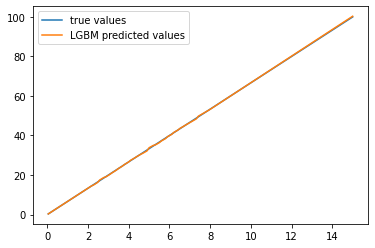

In [814]:
# Create an LGBM model
params = {
    'objective': 'regression',
    'linear_tree': True,
}
model = LGBMRegressor(**params)

# Create time serie timestamp indices
ts = np.linspace(0, 10, 100)
X = pd.DataFrame({'ts': ts})

# Generate signal to predict using a simple linear system
y = ts * 6.66

# Train LGBM model
model.fit(X, y)

# Create prediction inputs. Start with timestamp indices
# Shift the initial time range by 0.05 to force interpolation and augment if to force extrapolation
x_preds = pd.DataFrame({'ts': list(ts + 0.05) + [11, 12, 13, 14, 15]})
preds = model.predict(x_preds)
# Plot results.
# LGBM with linear tree can extrapolate
plt.plot(x_preds, x_preds['ts'] * 6.66, label='true values')
plt.plot(x_preds, preds, label='LGBM predicted values')
plt.legend()
# plt.savefig('lgbm_linear.png')
plt.show()

## Real Data

In [815]:
# Create an LGBM model
params = {
    'objective': 'regression',
    'linear_tree': True, #for forecasting
#     'lambda_l1 ': 0.2, 
}
model2 = LGBMRegressor(**params)

In [816]:
X = df[['Dev']]

In [817]:
X

,Dev
0,1
1,2
2,3
3,4
4,5
...,...
1519,2
1520,3
1521,4
1522,5


In [818]:
y = df['Loss']

<AxesSubplot:>

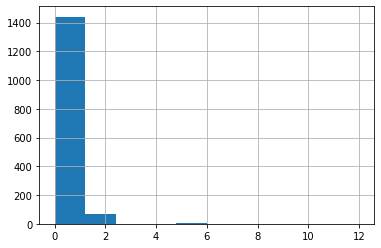

In [819]:
y.hist()

In [820]:
df.groupby('Dev').mean()

,Record,Loss,AY,EvalYr
Dev,,,,
1,127.5,0.000000,2001.559055,2002.559055
2,127.5,0.121063,2001.559055,2003.559055
3,127.5,0.151329,2001.559055,2004.559055
4,127.5,0.157382,2001.559055,2005.559055
5,127.5,0.169488,2001.559055,2006.559055
6,127.5,0.181594,2001.559055,2007.559055


In [821]:
# Train LGBM model
model2.fit(X, y)

LGBMRegressor(linear_tree=True, objective='regression')

In [822]:
y_pred = model2.predict(X)

In [823]:
y_pred

array([3.45677203e-06, 1.21063237e-01, 1.51328177e-01, ...,
       1.57381160e-01, 1.69487141e-01, 1.81593120e-01])

In [824]:
res_df = X.copy(deep=True)
res_df['Loss_pred'] = y_pred
res_df.head()

,Dev,Loss_pred
0,1,0.000003
1,2,0.121063
2,3,0.151328
3,4,0.157381
4,5,0.169487


In [825]:
res_df.groupby('Dev').mean()

,Loss_pred
Dev,
1,0.000003
2,0.121063
3,0.151328
4,0.157381
5,0.169487
6,0.181593


### Extrapolation

In [826]:
X_later = pd.DataFrame(np.linspace(1,10,10),columns=['Dev'])

res2_df = X_later.copy(deep=True)

res2_df["Loss_pred"] = model2.predict(X_later)


In [827]:
res2_df

,Dev,Loss_pred
0,1.0,0.000003
1,2.0,0.121063
2,3.0,0.151328
3,4.0,0.157381
4,5.0,0.169487
5,6.0,0.181593
6,7.0,0.189311
7,8.0,0.197028
8,9.0,0.204746
9,10.0,0.212463


**Successful extrapolation**

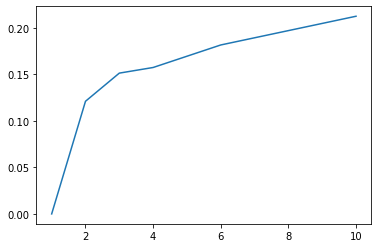

In [828]:
plt.plot(res2_df['Dev'],res2_df['Loss_pred'])

## Train Test Split w AY

In [829]:
df

,Record,Loss,Dev,AY,EvalYr
0,1,0.0000,1,2000,2001
1,1,1.7500,2,2000,2002
2,1,2.1875,3,2000,2003
3,1,2.2750,4,2000,2004
4,1,2.4500,5,2000,2005
...,...,...,...,...,...
1519,254,8.0000,2,2003,2005
1520,254,10.0000,3,2003,2006
1521,254,10.4000,4,2003,2007
1522,254,11.2000,5,2003,2008


In [830]:
split_yr =  df["AY"].unique()[-1] # use last as test
print(split_yr)
train_mask = df["AY"] < split_yr

2003


In [831]:
train_df = df.loc[train_mask,:]
test_df = df.loc[~train_mask,:]

In [832]:
train_df.groupby("Dev").mean()

,Record,Loss,AY,EvalYr
Dev,,,,
1,94.5,0.000000,2001.053191,2002.053191
2,94.5,0.094415,2001.053191,2003.053191
3,94.5,0.118019,2001.053191,2004.053191
4,94.5,0.122739,2001.053191,2005.053191
5,94.5,0.132181,2001.053191,2006.053191
6,94.5,0.141622,2001.053191,2007.053191


In [833]:
test_df.groupby("Dev").mean()

,Record,Loss,AY,EvalYr
Dev,,,,
1,221.5,0.000000,2003.0,2004.0
2,221.5,0.196970,2003.0,2005.0
3,221.5,0.246212,2003.0,2006.0
4,221.5,0.256061,2003.0,2007.0
5,221.5,0.275758,2003.0,2008.0
6,221.5,0.295455,2003.0,2009.0


## Split with EvalYr

In [834]:
df

,Record,Loss,Dev,AY,EvalYr
0,1,0.0000,1,2000,2001
1,1,1.7500,2,2000,2002
2,1,2.1875,3,2000,2003
3,1,2.2750,4,2000,2004
4,1,2.4500,5,2000,2005
...,...,...,...,...,...
1519,254,8.0000,2,2003,2005
1520,254,10.0000,3,2003,2006
1521,254,10.4000,4,2003,2007
1522,254,11.2000,5,2003,2008


In [835]:
split_yr =  df["EvalYr"].unique()[-1] # use last as test
print(split_yr)
train_mask = df["EvalYr"] < split_yr

2009


In [836]:
train_df = df.loc[train_mask,:]
test_df = df.loc[~train_mask,:]

In [837]:
train_df.groupby("Dev").mean()

,Record,Loss,AY,EvalYr
Dev,,,,
1,127.5,0.000000,2001.559055,2002.559055
2,127.5,0.121063,2001.559055,2003.559055
3,127.5,0.151329,2001.559055,2004.559055
4,127.5,0.157382,2001.559055,2005.559055
5,127.5,0.169488,2001.559055,2006.559055
6,94.5,0.141622,2001.053191,2007.053191


In [838]:
test_df.groupby("Dev").mean()

,Record,Loss,AY,EvalYr
Dev,,,,
6,221.5,0.295455,2003.0,2009.0


### remodel w 2 valid yrs

In [839]:
# test
X = train_df.loc[:,["Dev","AY"]]
y = train_df.loc[:,["Loss"]]

In [840]:
X_valid = train_df.loc[train_df["EvalYr"] >= (split_yr -2) ,["Dev","AY"]]
y_valid = train_df.loc[train_df["EvalYr"] >= (split_yr -2),["Loss"]]

In [841]:
# Create an LGBM model
params = {
    'boosting_type': 'gbdt', # reduce overfitting
    'objective': 'tweedie', #imbalanced dataset
    'linear_tree': True, #for forecasting
#     'lambda_l1 ': 0.2, 
    'max_depth': 2, # reduce interactions
    'learning_rate':0.01, # reduce extrapolation variance by keep low?
    'num_iterations':10000, # but learn for a long time
    'early_stopping_round': 30, # as long as there is improvemetn
    'random_state': 42,
    
}
model = LGBMRegressor(**params)

In [842]:
model.fit(X,y,eval_set= [(X_valid,y_valid)])

C:\Users\SW\.virtualenvs\casestudy1-meauSkPt\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's tweedie: 1.91401
[2]	valid_0's tweedie: 1.91261
[3]	valid_0's tweedie: 1.91121
[4]	valid_0's tweedie: 1.90989
[5]	valid_0's tweedie: 1.90855
[6]	valid_0's tweedie: 1.90728
[7]	valid_0's tweedie: 1.90617
[8]	valid_0's tweedie: 1.90472
[9]	valid_0's tweedie: 1.9035
[10]	valid_0's tweedie: 1.90229
[11]	valid_0's tweedie: 1.90111
[12]	valid_0's tweedie: 1.89995
[13]	valid_0's tweedie: 1.899
[14]	valid_0's tweedie: 1.89799
[15]	valid_0's tweedie: 1.89694
[16]	valid_0's tweedie: 1.89601
[17]	valid_0's tweedie: 1.89491
[18]	valid_0's tweedie: 1.89418
[19]	valid_0's tweedie: 1.89319
[20]	valid_0's tweedie: 1.89218
[21]	valid_0's tweedie: 1.8915
[22]	valid_0's tweedie: 1.89056
[23]	valid_0's tweedie: 1.88963
[24]	valid_0's tweedie: 1.88878
[25]	valid_0's tweedie: 1.88791
[26]	valid_0's tweedie: 1.88668
[27]	valid_0's tweedie: 1.88594
[28]	valid_0's tweedie: 1.88634
[29]	valid_0's tweedie: 1.88555
[30]	valid_0's tweedie: 1.88468
[31]	valid_0's tweedie: 1.88374
[32]	valid_0's tweedi

[260]	valid_0's tweedie: 1.83347
[261]	valid_0's tweedie: 1.83344
[262]	valid_0's tweedie: 1.83341
[263]	valid_0's tweedie: 1.83339
[264]	valid_0's tweedie: 1.83336
[265]	valid_0's tweedie: 1.83333
[266]	valid_0's tweedie: 1.83331
[267]	valid_0's tweedie: 1.83329
[268]	valid_0's tweedie: 1.83327
[269]	valid_0's tweedie: 1.83325
[270]	valid_0's tweedie: 1.83323
[271]	valid_0's tweedie: 1.8332
[272]	valid_0's tweedie: 1.83318
[273]	valid_0's tweedie: 1.83315
[274]	valid_0's tweedie: 1.83316
[275]	valid_0's tweedie: 1.83313
[276]	valid_0's tweedie: 1.83311
[277]	valid_0's tweedie: 1.8331
[278]	valid_0's tweedie: 1.83307
[279]	valid_0's tweedie: 1.83305
[280]	valid_0's tweedie: 1.83303
[281]	valid_0's tweedie: 1.83301
[282]	valid_0's tweedie: 1.83303
[283]	valid_0's tweedie: 1.83301
[284]	valid_0's tweedie: 1.83298
[285]	valid_0's tweedie: 1.83297
[286]	valid_0's tweedie: 1.83295
[287]	valid_0's tweedie: 1.83293
[288]	valid_0's tweedie: 1.83291
[289]	valid_0's tweedie: 1.83289
[290]	valid_

[520]	valid_0's tweedie: 1.83174
[521]	valid_0's tweedie: 1.83174
[522]	valid_0's tweedie: 1.83174
[523]	valid_0's tweedie: 1.83174
[524]	valid_0's tweedie: 1.83174
[525]	valid_0's tweedie: 1.83174
[526]	valid_0's tweedie: 1.83174
[527]	valid_0's tweedie: 1.83174
[528]	valid_0's tweedie: 1.83174
[529]	valid_0's tweedie: 1.83174
[530]	valid_0's tweedie: 1.83173
[531]	valid_0's tweedie: 1.83173
[532]	valid_0's tweedie: 1.83173
[533]	valid_0's tweedie: 1.83173
[534]	valid_0's tweedie: 1.83173
[535]	valid_0's tweedie: 1.83173
[536]	valid_0's tweedie: 1.83173
[537]	valid_0's tweedie: 1.83173
[538]	valid_0's tweedie: 1.83173
[539]	valid_0's tweedie: 1.83173
[540]	valid_0's tweedie: 1.83173
[541]	valid_0's tweedie: 1.83173
[542]	valid_0's tweedie: 1.83173
[543]	valid_0's tweedie: 1.83173
[544]	valid_0's tweedie: 1.83173
[545]	valid_0's tweedie: 1.83173
[546]	valid_0's tweedie: 1.83173
[547]	valid_0's tweedie: 1.83173
[548]	valid_0's tweedie: 1.83173
[549]	valid_0's tweedie: 1.83173
[550]	vali

LGBMRegressor(early_stopping_round=30, learning_rate=0.01, linear_tree=True,
              max_depth=2, num_iterations=10000, objective='tweedie',
              random_state=42)

In [843]:
model.predict(test_df[["Dev","AY"]])

array([0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831])

In [844]:
model.predict(test_df[["Dev","AY"]])

array([0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831, 0.29207831, 0.29207831, 0.29207831, 0.29207831,
       0.29207831])

### Extrapolation v2 dev

In [845]:
X_later

,Dev
0,1.0
1,2.0
2,3.0
3,4.0
4,5.0
5,6.0
6,7.0
7,8.0
8,9.0
9,10.0


In [846]:
X_later = pd.DataFrame({"Dev":np.linspace(1,10,10),"AY": np.ones(10)*2002})

res2_df = X_later.copy(deep=True)

res2_df["Loss_pred"] = model.predict(X_later)


In [847]:
res2_df

,Dev,AY,Loss_pred
0,1.0,2002.0,0.000003
1,2.0,2002.0,0.139954
2,3.0,2002.0,0.169605
3,4.0,2002.0,0.179381
4,5.0,2002.0,0.189720
5,6.0,2002.0,0.200655
6,7.0,2002.0,0.212220
7,8.0,2002.0,0.224452
8,9.0,2002.0,0.237388
9,10.0,2002.0,0.251071


**Successful extrapolation**

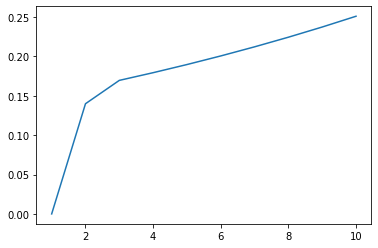

In [848]:
plt.plot(res2_df['Dev'],res2_df['Loss_pred'])

### Extrapolation v3 ay

In [849]:
X_later = pd.DataFrame([[6,2000],[6,2001],[6,2002],[6,2003],[6,2004],[6,2005],[6,2007]],columns=['Dev',"AY"])

res2_df = X_later.copy(deep=True)

res2_df["Loss_pred"] = model.predict(X_later)


In [850]:
res2_df

,Dev,AY,Loss_pred
0,6,2000,0.074800
1,6,2001,0.136240
2,6,2002,0.200655
3,6,2003,0.292078
4,6,2004,0.309820
5,6,2005,0.328639
6,6,2007,0.369777


**Successful extrapolation of dev**

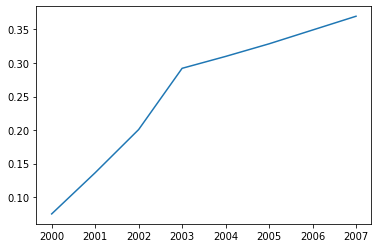

In [851]:
plt.plot(res2_df['AY'],res2_df['Loss_pred'])

**Successful extrapolation of AY trend**